In [ ]:
pip install alpha_shapes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


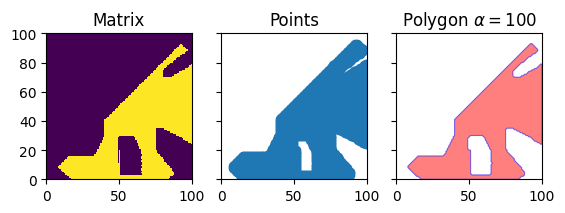

In [13]:
from alpha_shapes import Alpha_Shaper, plot_alpha_shape
from osgeo import ogr
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt


def matrix2points_corners(matrix:npt.ArrayLike) -> list:
    points = []
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            if matrix[y,x] == 1:
                points.append((x,y))
                points.append((x+1,y))
                points.append((x,y+1))
                points.append((x+1,y+1))

    return list(set(points))


def matrix2points_centre(matrix:npt.ArrayLike) -> list:
    points = []
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            if matrix[y,x] == 1:
                points.append((x+0.5,y+0.5))

    return list(set(points))


def save_alpha_shape_to_shpfile(alphashape, filename='alpha_shape.shp'):

    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(f'{filename}')
    layer = ds.CreateLayer('', None, ogr.wkbPolygon)
    layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
    defn = layer.GetLayerDefn()

    feat = ogr.Feature(defn)
    feat.SetField('id', 123)

    geom = ogr.CreateGeometryFromWkb(alphashape.wkb)
    feat.SetGeometry(geom)

    layer.CreateFeature(feat)
    feat = geom = None  # destroy these

    # Save and close everything
    ds = layer = feat = geom = None
    
    return


if __name__ == "__main__":

    # Complex matrix for testing
    M0 = np.load("./visible_points.npy")

    # Simple matrices for testing
    M1 = np.array([[0,0,0],[0,1,0],[0,0,0],[0,0,0]]) # single point
    M2 = np.array([[1,1,1,1],[1,0,0,1],[1,0,0,1],[1,0,0,1]]) # U shape
    M3 = np.array([[1,1,1,1],[1,0,0,1],[1,0,0,1],[1,1,1,1]]) # small hole
    M4 = np.array([[1,1,1,1,1,1,1,1],[1,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,1],[1,1,1,1,1,1,1,1]]) # big hole
    M5 = np.array([[1,0,0,1],[1,0,0,1],[1,0,0,1],[0,0,0,0]]) # divided set

    matrix_to_run = M0
    matrix_points_corners = matrix2points_corners(matrix_to_run)
    matrix_points_centre = matrix2points_centre(matrix_to_run)

    alpha_auto = False
    alpha = 100
    alpha_shaper = Alpha_Shaper(matrix_points_corners)
    if alpha_auto:
        alpha, alpha_shape = alpha_shaper.optimize()
    else:
        alpha_shape = alpha_shaper.get_shape(alpha=alpha)

    save = True
    save_to = './alpha_shape.shp'
    if save:
        save_alpha_shape_to_shpfile(alpha_shape, save_to)

    # Plot matrix, points, and polygons
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharex=True, sharey=True)

    ax0.pcolormesh(matrix_to_run)
    ax0.set_title('Matrix')
    ax0.axis('scaled')

    ax1.scatter(*zip(*matrix_points_corners))
    ax1.set_title("Points")

    plot_alpha_shape(ax2, alpha_shape)
    ax2.set_title(f"Polygon $\\alpha={np.round(alpha,2)}$")

    for ax in (ax0, ax1, ax2):
        ax.set_aspect('equal')

    plt.show()